In [1]:
from general_functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from varname import nameof
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn.metrics import make_scorer, fbeta_score

# Import Data

In [2]:
conf_data = pd.read_csv('conf_data.csv')
ts_data = pd.read_csv('ts_data4.csv')

# Data Understending
## conf_data

In [3]:
dataset_initial_understanding(conf_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   d_id      10200 non-null  int64 
 1   age       10200 non-null  int64 
 2   capacity  10200 non-null  object
 3   model     10200 non-null  object
 4   fail      10200 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 328.8+ KB
None


   d_id  age capacity    model  fail
0     1   15      1TB  Hitachi  True
1     2   23      1TB  Fujitsu  True
2     3   23      1TB  Seagate  True
3     4   14      1TB  Hitachi  True
4     5   18    600GB  Hitachi  True


Missing values - Preliminary inspection
d_id        0.0
age         0.0
capacity    0.0
model       0.0
fail        0.0
dtype: float64


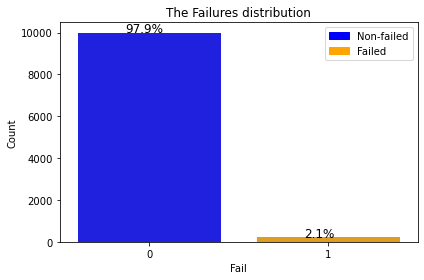

In [4]:
plot_target_distribution(conf_data)

### Numeric Variables

In [5]:
# Convert to continuous values of the same scale
conf_data['capacity'].nunique()  # ['1TB', '600GB', '300GB']
capacity_dict = {'1TB': 1, '600GB': 0.6, '300GB': 0.3}
conf_data['capacity'] = conf_data['capacity'].apply(lambda x: capacity_dict[x])
# verify - conf_data['capacity'].unique() # [1. , 0.6, 0.3]

conf_data_numeric_describe = conf_data.iloc[:, 1:].describe().transpose()
print(conf_data_numeric_describe)

            count       mean       std  min   25%   50%   75%   max
age       10200.0  16.076961  4.005029  3.0  13.0  16.0  19.0  35.0
capacity  10200.0   0.671961  0.292901  0.3   0.3   0.6   1.0   1.0
fail      10200.0   0.020686  0.142339  0.0   0.0   0.0   0.0   1.0


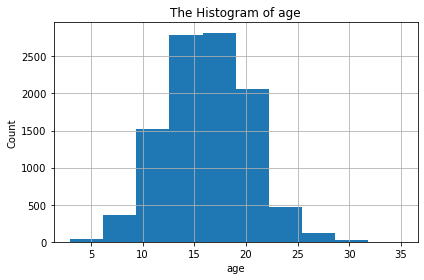

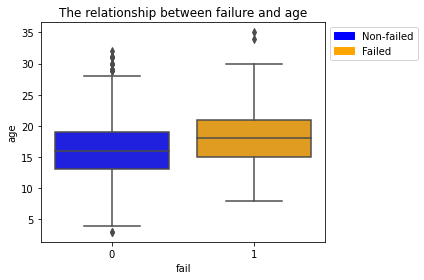

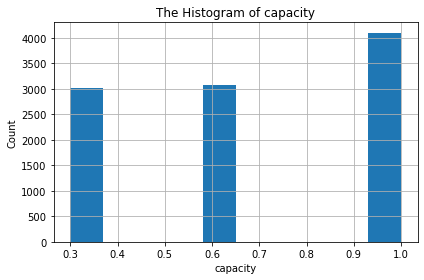

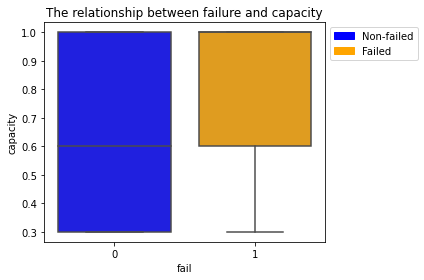

In [6]:
for val in conf_data_numeric_describe.index[:-1]:
    plot_hist(conf_data[val], val)
    plot_relation_numeric_to_target(conf_data, val)

### Categorical variables

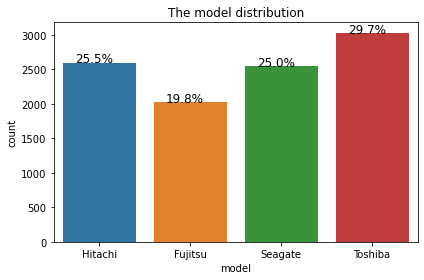

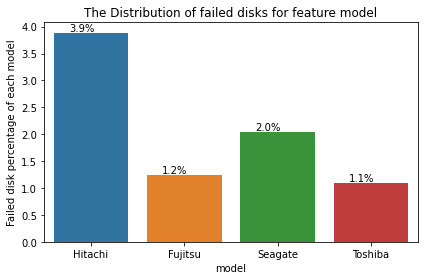

In [7]:
# Merge identical categories with a capitalization difference
conf_data['model'].nunique()  # ['Hitachi', 'Fujitsu', 'Seagate', 'Toshiba', 'seagate', 'fujitsu','toshiba']
conf_data['model'] = conf_data['model'].apply(lambda x: x[0].upper() + x[1:])
# verify - conf_data['model'].nunique() # ['Hitachi', 'Fujitsu', 'Seagate', 'Toshiba']

conf_data['model'] = pd.Categorical(conf_data['model'], categories=['Hitachi', 'Fujitsu', 'Seagate', 'Toshiba'], ordered=True)
plot_categorical_distribution(conf_data['model'], 'model')
plot_relation_categorical_to_target(conf_data, 'model')

## ts_data

In [8]:
dataset_initial_understanding(ts_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   d_id              204000 non-null  int64 
 1   time              204000 non-null  object
 2   bb_count          204000 non-null  int64 
 3   r-w_rate          204000 non-null  int64 
 4   reconsects_count  204000 non-null  int64 
 5   recovbydrv_count  204000 non-null  int64 
 6   xfer_rate         204000 non-null  int64 
 7   dd_diffs          204000 non-null  int64 
 8   fail              204000 non-null  bool  
dtypes: bool(1), int64(7), object(1)
memory usage: 12.6+ MB
None


   d_id time  bb_count  r-w_rate  reconsects_count  recovbydrv_count  \
0     1   V1        -5        14                 0                 9   
1     1   V2         5        15                 0                17   
2     1   V3        14        11                 0                24   
3     1   V4      

### Numeric variables

In [9]:
# Convert time variable to numeric values
ts_data['time'] = ts_data['time'].apply(lambda x: int(x[1:]))

#### Count variables

In [10]:
count_vars_cols_names = ['Feature', 'Samples with a negative value', 'Percentage of failed disks with negative values']
count_vars_summary_data = pd.DataFrame([], columns=count_vars_cols_names)
count_feature_names = ['bb_count', 'reconsects_count', 'recovbydrv_count']
disks_id_to_remove = []
for f in count_feature_names:
    disks_id_without_fail_with_negative_list, fail_percentage_subset = fail_percentage_negative_values(ts_data, f)
    disks_id_to_remove = list(set(disks_id_to_remove + disks_id_without_fail_with_negative_list))
    count_vars_summary_data = pd.concat([count_vars_summary_data, pd.DataFrame([[f, np.round(ts_data[f][ts_data[f] < 0].count(), 1), int(fail_percentage_subset)]], columns=count_vars_cols_names)])
display(count_vars_summary_data)

## deleting disks without failures but with negative value of count variables
conf_data = conf_data[~conf_data['d_id'].isin(disks_id_to_remove)]
ts_data = ts_data[~ts_data['d_id'].isin(disks_id_to_remove)]

## replace negative values with average
ts_data = replace_negative_vals_average(ts_data, 'bb_count')
ts_data = replace_negative_vals_average(ts_data, 'reconsects_count')
ts_data = replace_negative_vals_average(ts_data, 'recovbydrv_count')

,Feature,Samples with a negative value,Percentage of failed disks with negative values
0,bb_count,5492,30
0,reconsects_count,177,6
0,recovbydrv_count,730,3


In [11]:
ts_data_numeric_describe = ts_data.describe().transpose()
print(ts_data_numeric_describe)

                     count         mean          std   min      25%     50%  \
d_id              165780.0  5084.793220  2961.257118   1.0  2504.00  5102.0   
time              165780.0    10.500000     5.766299   1.0     5.75    10.5   
bb_count          165780.0   107.895422    61.808474   0.0    60.00    99.0   
r-w_rate          165780.0    10.109941     4.574896   0.0     7.00    10.0   
reconsects_count  165780.0    38.575480    27.836859   0.0    17.00    31.0   
recovbydrv_count  165780.0   140.785469    76.731527   2.0    79.00   131.0   
xfer_rate         165780.0    75.489546    12.701694  29.0    67.00    75.0   
dd_diffs          165780.0     2.970310     2.460500   0.0     1.00     3.0   
fail              165780.0     0.025335     0.157140   0.0     0.00     0.0   

                      75%      max  
d_id              7659.00  10200.0  
time                15.25     20.0  
bb_count           146.00    515.0  
r-w_rate            13.00     41.0  
reconsects_count    53.0

### Comparison between datasets
#### Comparing the disk ids between the 2 data sets

In [12]:
if (conf_data['d_id'].unique() == ts_data['d_id'].unique()).all():
    print('Both datasets contain the same disk ids')
else:
    print('The datasets do not contain the same disk ids')

Both datasets contain the same disk ids


#### Comparing target variable

In [13]:
print('The number of unique disk ids with failures in the ' + nameof(conf_data) + ' dataset is: ' + str(conf_data['fail'].sum()))
aggregate_ts_data_by_id = ts_data.groupby(['d_id']).mean()
print('The number of unique disk ids with failures in the ' + nameof(ts_data) + ' dataset is: ' + str(int(aggregate_ts_data_by_id['fail'].sum())))

The number of unique disk ids with failures in the conf_data dataset is: 211
The number of unique disk ids with failures in the ts_data dataset is: 210


There is one unreliable sample.  
The sample is classified as a failed disk in conf_data and as a non-failed disk in ts_data.  
Finding the unreliable sample.

In [14]:
conf_data_labels = conf_data[conf_data['fail'] == 1]['d_id'].tolist()
ts_data_labels = list(aggregate_ts_data_by_id[aggregate_ts_data_by_id['fail'] == 1].index)
unreliable_sample_d_id = (set(conf_data_labels) - set(ts_data_labels)).pop()
print(unreliable_sample_d_id)

## remove unreliable sample
conf_data = remove_disk_id(conf_data, unreliable_sample_d_id)
ts_data = remove_disk_id(ts_data, unreliable_sample_d_id)

211


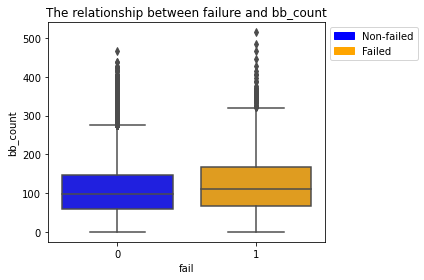

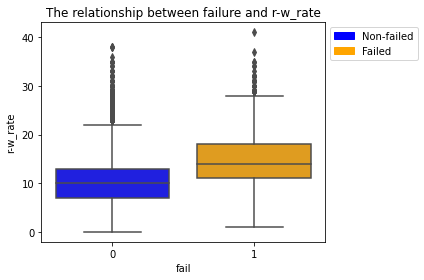

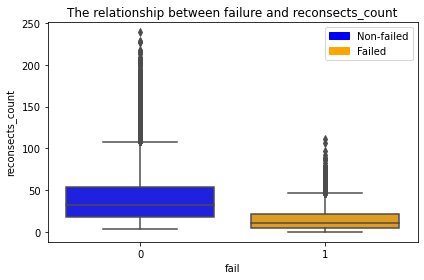

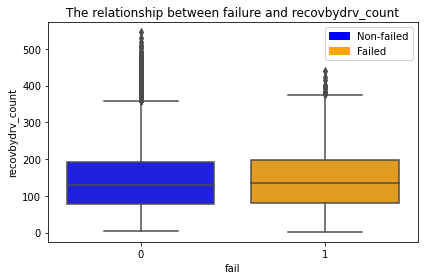

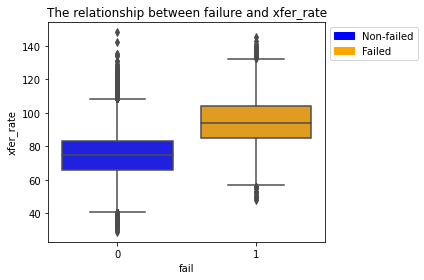

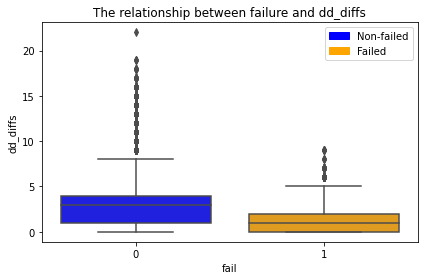

In [15]:
for val in ts_data_numeric_describe.index[2:-1]:
    # plot_hist(ts_data[val], val)
    plot_relation_numeric_to_target(ts_data, val)

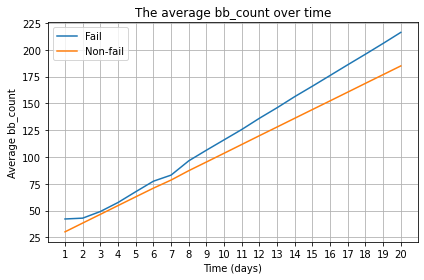

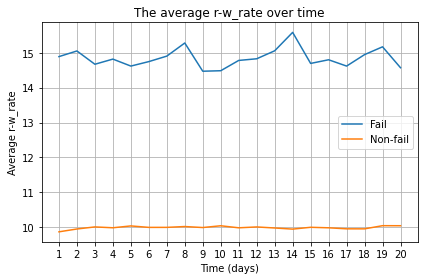

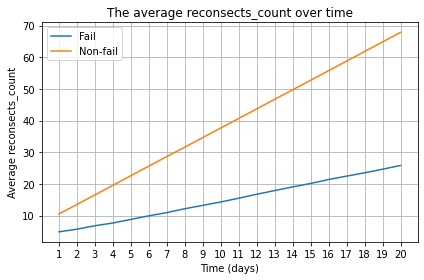

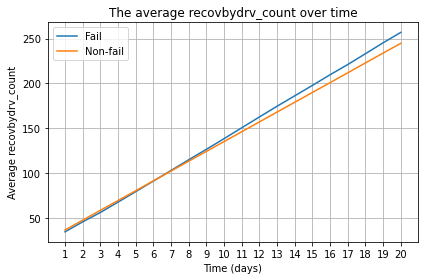

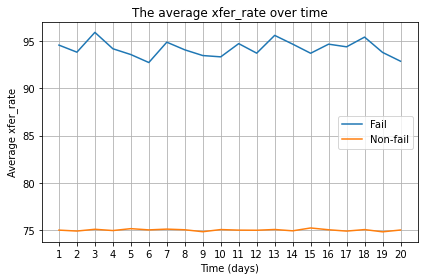

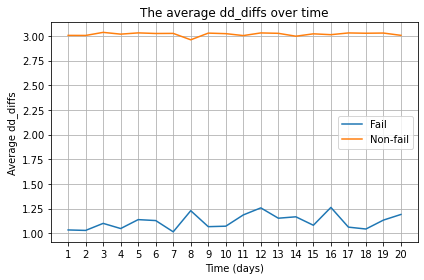

In [16]:
# Time series visualization
aggregate_ts_data_by_time_fail = ts_data.iloc[:, 1:].groupby(['time', 'fail']).mean()
timeline = range(1, 21)
average_fail_behavior = aggregate_ts_data_by_time_fail[aggregate_ts_data_by_time_fail.index.isin([1], level=1)]
average_non_fail_behavior = aggregate_ts_data_by_time_fail[aggregate_ts_data_by_time_fail.index.isin([0], level=1)]

for col in aggregate_ts_data_by_time_fail.columns:
    plt.figure()
    plt.plot(timeline, average_fail_behavior.loc[:, col].to_numpy(), label='Fail')
    plt.plot(timeline, average_non_fail_behavior.loc[:, col].to_numpy(), label='Non-fail')
    plt.title('The average ' + col + ' over time')
    plt.xticks(timeline)
    plt.xlabel('Time (days)')
    plt.ylabel('Average ' + col)
    plt.legend()
    plt.grid()
    plt.show()

# Feature Engineering
## Age as a categorical feature

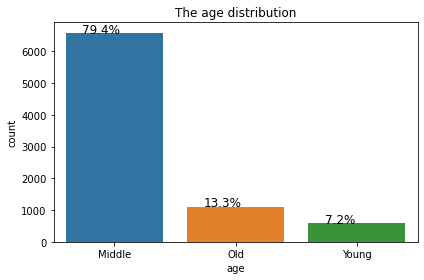

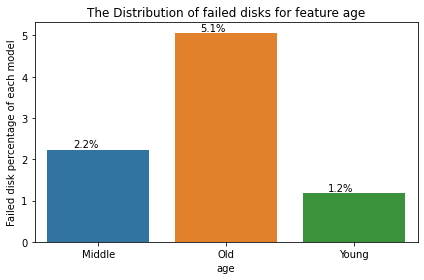

The percentage of failed disks for each age group is


In [17]:
max_age_first_group = 10
max_age_second_group = 20

first_group_mask = conf_data['age'] <= max_age_first_group
second_group_mask = (conf_data['age'] > max_age_first_group) & (conf_data['age'] <= max_age_second_group)
third_group_mask = conf_data['age'] > max_age_second_group

conf_data.loc[first_group_mask, 'age'] = 'Young'
conf_data.loc[second_group_mask, 'age'] = 'Middle'
conf_data.loc[third_group_mask, 'age'] = 'Old'

plot_categorical_distribution(conf_data['age'], 'age')
plot_relation_categorical_to_target(conf_data, 'age')

print('The percentage of failed disks for each age group is')

## Using summary statistics as features
### Extracting average & std

In [18]:
variable_names_for_mean_std = ['r-w_rate', 'xfer_rate', 'dd_diffs']
aggregate_ts_data_by_id_mean = ts_data.loc[:, ['d_id'] + variable_names_for_mean_std].groupby(['d_id']).mean()
aggregate_ts_data_by_id_std = ts_data.loc[:, ['d_id'] + variable_names_for_mean_std].groupby(['d_id']).std()

### Extracting slope & intercept

In [19]:
variable_names_for_slope = ['bb_count', 'reconsects_count', 'recovbydrv_count']
aggregate_ts_data_by_slope = pd.DataFrame([])
aggregate_ts_data_by_intercept = pd.DataFrame([])
for var in variable_names_for_slope:
    slope_intercept_aggregate = get_slope_intercept(ts_data, timeline, var)
    aggregate_ts_data_by_slope = pd.concat([aggregate_ts_data_by_slope, slope_intercept_aggregate['slope'].rename(var)], axis=1)
    aggregate_ts_data_by_intercept = pd.concat([aggregate_ts_data_by_intercept, slope_intercept_aggregate['intercept'].rename(var)], axis=1)

# Preparing for modeling

In [20]:
conf_data.index = conf_data['d_id']
add_statistic_feature(conf_data, aggregate_ts_data_by_id_mean, 'mean')
add_statistic_feature(conf_data, aggregate_ts_data_by_id_std, 'std')
add_statistic_feature(conf_data, aggregate_ts_data_by_slope, 'slope')
add_statistic_feature(conf_data, aggregate_ts_data_by_intercept, 'intercept')

dataset_initial_understanding(conf_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8288 entries, 1 to 10200
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   d_id                        8288 non-null   int64   
 1   age                         8288 non-null   object  
 2   capacity                    8288 non-null   float64 
 3   model                       8288 non-null   category
 4   fail                        8288 non-null   int32   
 5   mean_r-w_rate               8288 non-null   float64 
 6   mean_xfer_rate              8288 non-null   float64 
 7   mean_dd_diffs               8288 non-null   float64 
 8   std_r-w_rate                8288 non-null   float64 
 9   std_xfer_rate               8288 non-null   float64 
 10  std_dd_diffs                8288 non-null   float64 
 11  slope_bb_count              8288 non-null   float64 
 12  slope_reconsects_count      8288 non-null   float64 
 13  slope_recovbydrv_

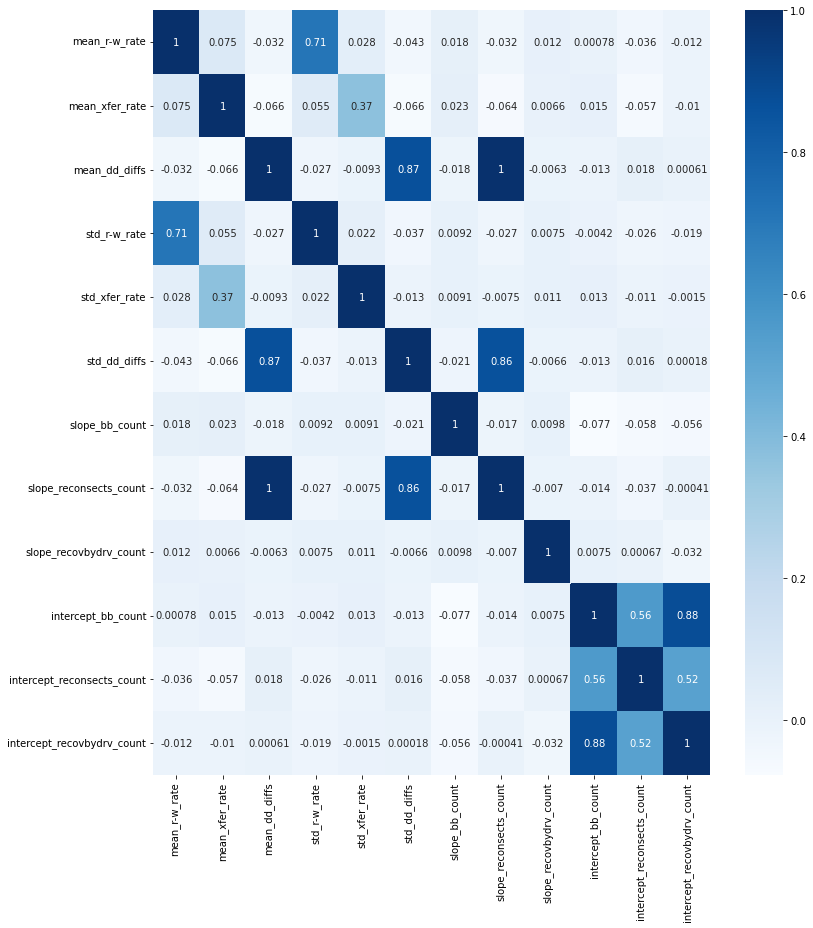

In [21]:
corr = conf_data.iloc[:, 5:].corr()
plt.figure(figsize=(12, 13))
sns.heatmap(corr, cmap='Blues', annot=True)

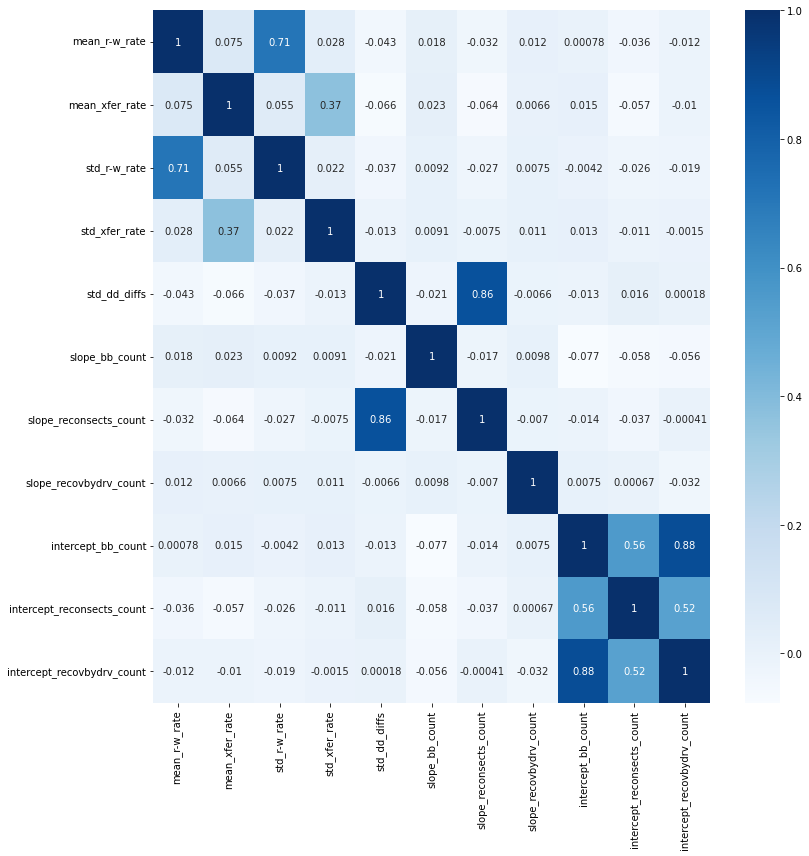

In [22]:
# remove correlated variables
var_to_remove = ['mean_dd_diffs']
conf_data = conf_data.drop(var_to_remove, axis=1)

corr = conf_data.iloc[:, 5:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='Blues', annot=True)

In [23]:
# Variance Inflation Factor
df_for_vif = conf_data.loc[:, ['slope_reconsects_count', 'std_dd_diffs', 'intercept_bb_count', 'intercept_recovbydrv_count']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = df_for_vif.columns
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(df_for_vif.values, i) for i in range(len(df_for_vif.columns))]

print(vif_data)

                      feature        VIF
0      slope_reconsects_count  13.700750
1                std_dd_diffs  17.482622
2          intercept_bb_count   9.317944
3  intercept_recovbydrv_count  13.638156


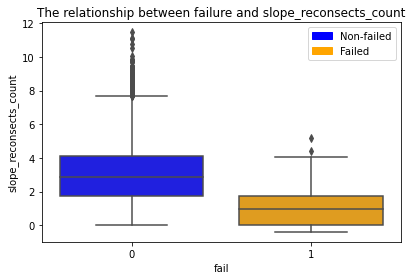

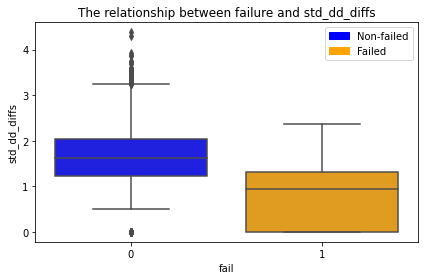

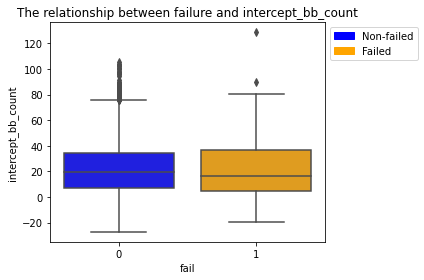

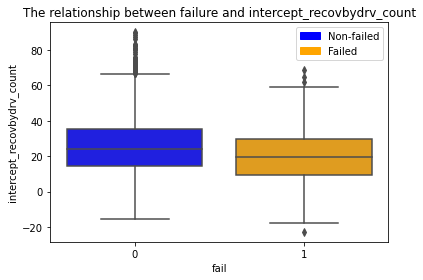

In [24]:
for val in df_for_vif.columns:
    plot_relation_numeric_to_target(conf_data, val)

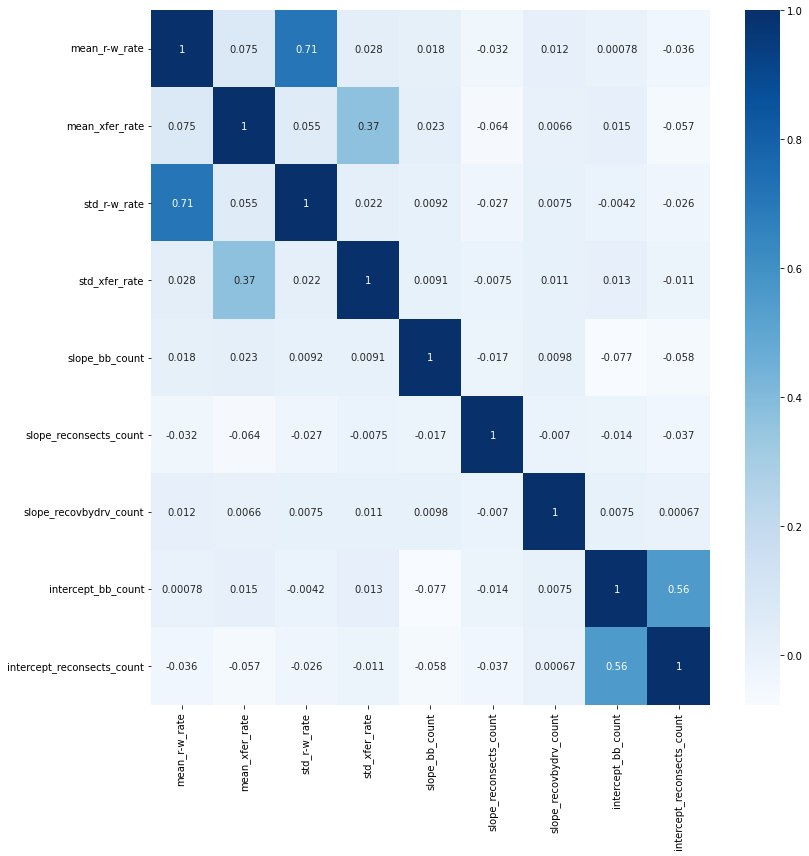

In [25]:
# remove correlated variables
var_to_remove = ['intercept_recovbydrv_count', 'std_dd_diffs']
conf_data = conf_data.drop(var_to_remove, axis=1)

corr = conf_data.iloc[:, 5:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='Blues', annot=True)

### ONE HOT ENCODING

In [26]:
conf_data = conf_data.drop(['d_id'], axis=1)
model_data = conf_data.select_dtypes(include=[object, 'category'])
conf_data = conf_data.select_dtypes(exclude=[object, 'category'])
data_to_split = pd.concat([conf_data, pd.get_dummies(model_data)], axis=1)
data_to_split.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8288 entries, 1 to 10200
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   capacity                    8288 non-null   float64
 1   fail                        8288 non-null   int32  
 2   mean_r-w_rate               8288 non-null   float64
 3   mean_xfer_rate              8288 non-null   float64
 4   std_r-w_rate                8288 non-null   float64
 5   std_xfer_rate               8288 non-null   float64
 6   slope_bb_count              8288 non-null   float64
 7   slope_reconsects_count      8288 non-null   float64
 8   slope_recovbydrv_count      8288 non-null   float64
 9   intercept_bb_count          8288 non-null   float64
 10  intercept_reconsects_count  8288 non-null   float64
 11  age_Middle                  8288 non-null   uint8  
 12  age_Old                     8288 non-null   uint8  
 13  age_Young                   8288

# Handling imbalance data and data splitting

In [27]:
X_train, X_test , y_train, y_test = train_test_split(data_to_split.drop(['fail'], axis=1), data_to_split['fail'], stratify = data_to_split['fail'], random_state=1)

In [28]:
# Handling imbalance data - resampling without replacement
# Separate majority and minority classes
df_imbalance = pd.concat([X_train, y_train], axis=1)
df_majority = df_imbalance[df_imbalance.fail == 0]
df_minority = df_imbalance[df_imbalance.fail == 1]
multiplied_by = 10
n_samples_required = df_minority.shape[0] * multiplied_by
# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_samples_required, random_state=123)
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
X_train, y_train = df_downsampled.drop(['fail'], axis=1), df_downsampled['fail']

In [29]:
old_failed_rate = data_to_split['fail'].mean()
new_failed_rate = y_train.mean()
new_class_weights = {1: 1, 0: np.round(new_failed_rate/old_failed_rate, 3)}
print(new_class_weights)

{1: 1, 0: 3.588}


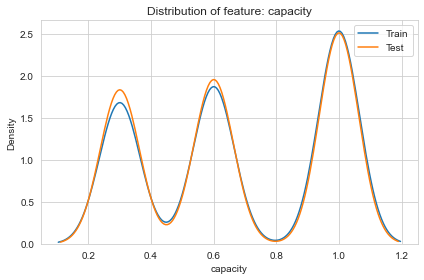

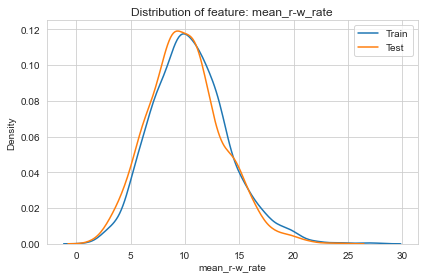

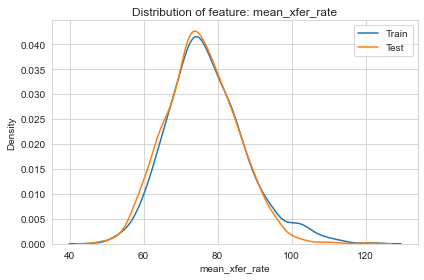

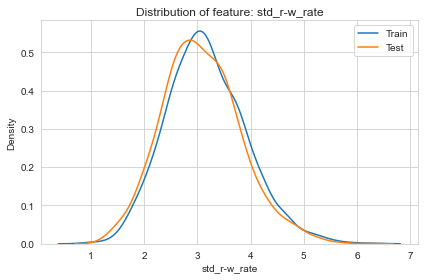

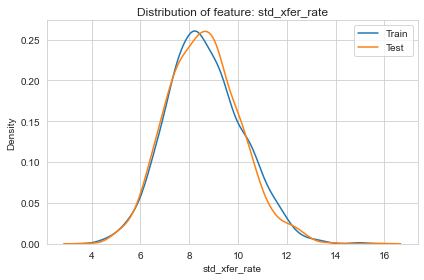

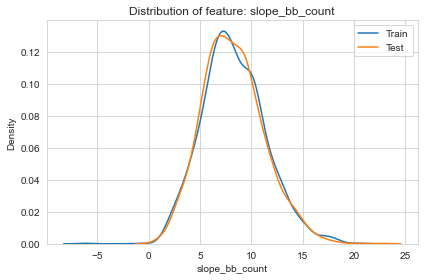

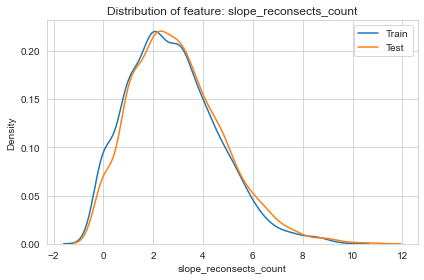

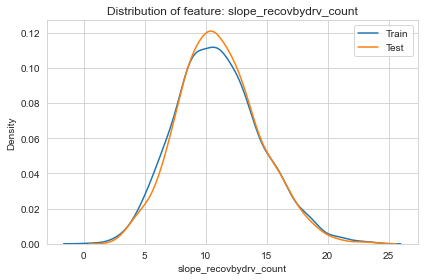

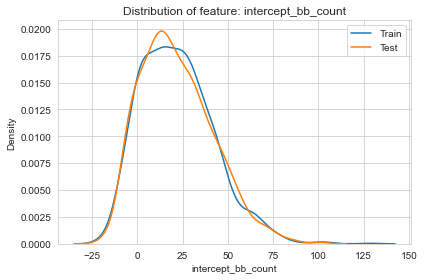

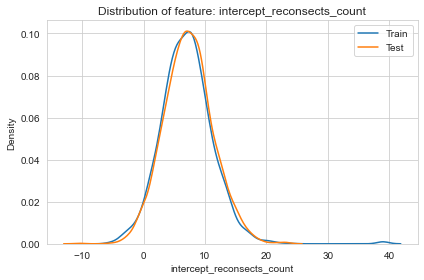

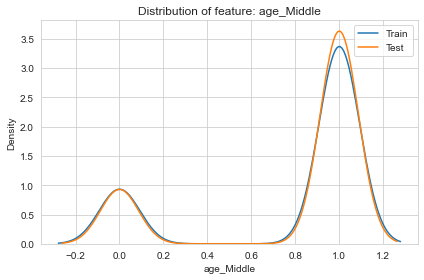

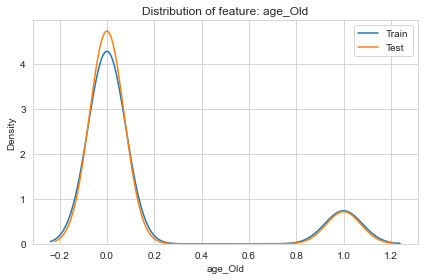

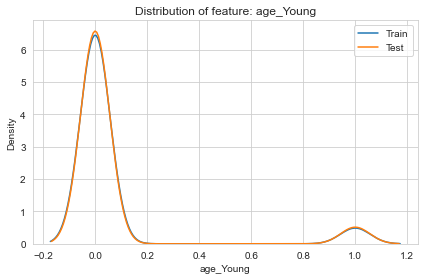

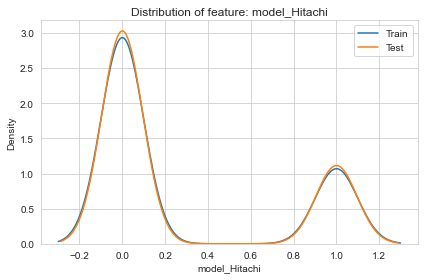

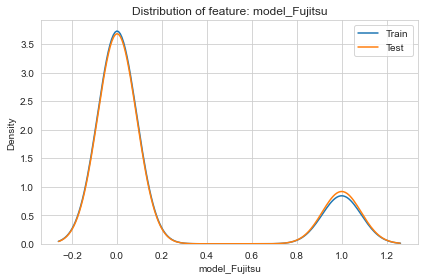

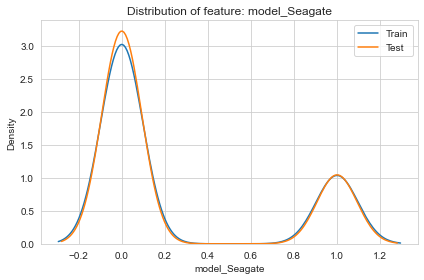

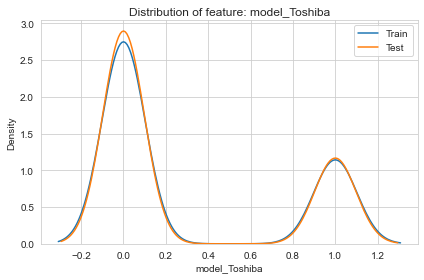

In [30]:
test_train_distribution(X_train, X_test)

# Modeling
## Base model: Logistic Regression

In [31]:
# Tuning
LR_model = LogisticRegression()
LR_grid = {'solver': ['liblinear'],
           'penalty': ['l1', 'l2'],
           'C': [100, 10, 1.0, 0.1, 0.01],
           'class_weight': ['balanced', new_class_weights, None],
           'max_iter': [200, 300]
            }
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
LR_grid_search = GridSearchCV(estimator=LR_model, param_grid=LR_grid, cv=cv, scoring='f1')
LR_chosen_model = tuning_hyperparameters(LR_grid_search, X_train, y_train)

# fit model
LR_y_pred_test, LR_y_pred_train, LR_y_pred_probs = fit_mode(LR_chosen_model, X_train, y_train, X_test)

Best: 0.836915 using {'C': 10, 'class_weight': None, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}


** Train evaluation **
The f1 score is 0.84
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1570
           1       0.91      0.78      0.84       157

    accuracy                           0.97      1727
   macro avg       0.94      0.89      0.91      1727
weighted avg       0.97      0.97      0.97      1727



** Test evaluation **
The f1 score is 0.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2019
           1       0.86      0.83      0.85        53

    accuracy                           0.99      2072
   macro avg       0.93      0.91      0.92      2072
weighted avg       0.99      0.99      0.99      2072

The precision-recall AUC is 0.9


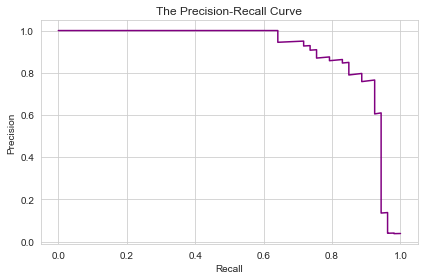

In [32]:
# Train and test evaluation
evaluation(y_train, LR_y_pred_train, y_test, LR_y_pred_test, LR_y_pred_probs)

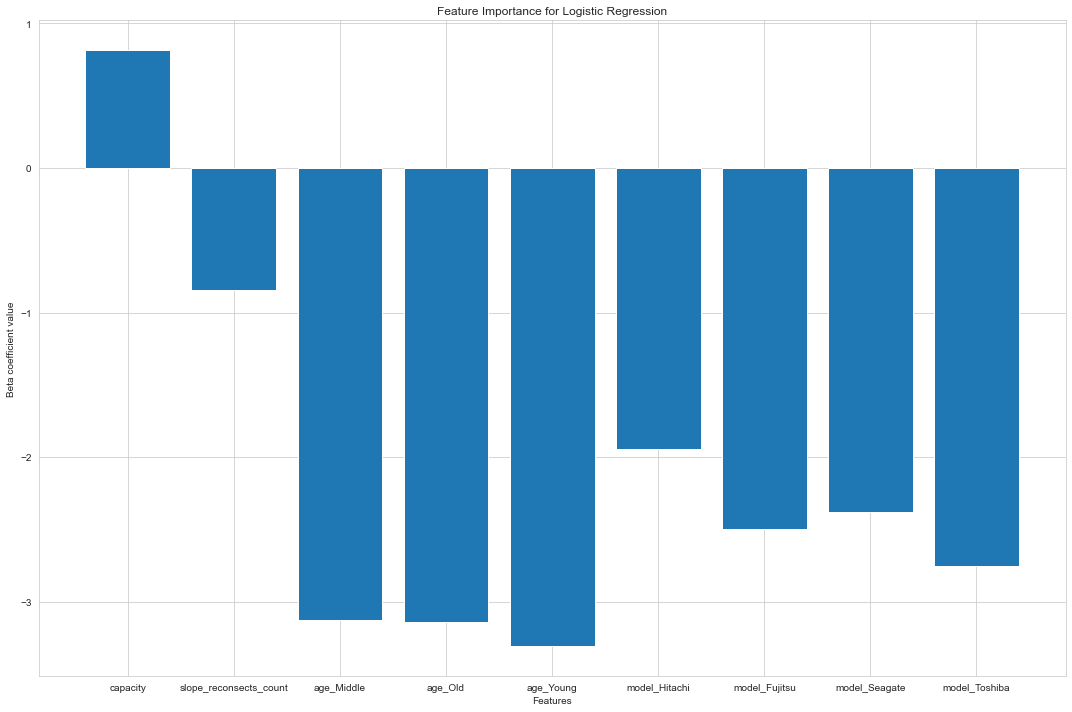

In [33]:
# get importance
importance = LR_chosen_model.coef_[0]
# plot feature importance
most_importance = pd.Series(importance, index=X_test.columns)
treshold = 0.4
most_importance = most_importance.iloc[np.where(abs(most_importance) >= treshold)]
plt.figure(figsize=(15, 10))
plt.bar(most_importance.index, most_importance.T.values.tolist())
plt.ylabel('Beta coefficient value')
plt.xlabel('Features')
plt.title('Feature Importance for Logistic Regression')
plt.show()

## Advanced model: Random Forest

In [34]:
# Tuning
RF_model = RandomForestClassifier(random_state=42)
RF_grid = {'max_depth': list(range(10, 101, 10)),
            'n_estimators': list(range(10, 101, 10)),
            'max_features': ['sqrt', 'auto', 'log2'],
            'min_samples_split': list(range(5, 101, 5)),
            'min_samples_leaf': list(range(4, 41, 4)),
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced', 'balanced_subsample']
            }
RF_random_search = RandomizedSearchCV(estimator=RF_model, param_distributions=RF_grid, n_iter=100, cv=cv, scoring='f1', random_state=42)
RF_chosen_model = tuning_hyperparameters(RF_random_search, X_train, y_train)

# fit model
RF_y_pred_test, RF_y_pred_train, RF_y_pred_probs = fit_mode(RF_chosen_model, X_train, y_train, X_test)

Best: 0.839773 using {'n_estimators': 80, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}


** Train evaluation **
The f1 score is 0.93
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1570
           1       0.91      0.95      0.93       157

    accuracy                           0.99      1727
   macro avg       0.95      0.97      0.96      1727
weighted avg       0.99      0.99      0.99      1727



** Test evaluation **
The f1 score is 0.76
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2019
           1       0.69      0.85      0.76        53

    accuracy                           0.99      2072
   macro avg       0.84      0.92      0.88      2072
weighted avg       0.99      0.99      0.99      2072

The precision-recall AUC is 0.87


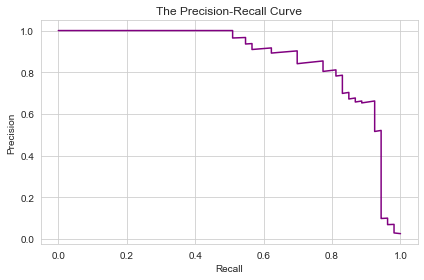

In [35]:
# Train and test evaluation
evaluation(y_train, RF_y_pred_train, y_test, RF_y_pred_test, RF_y_pred_probs)

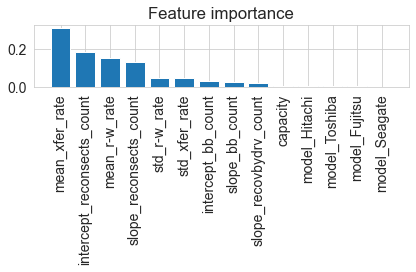

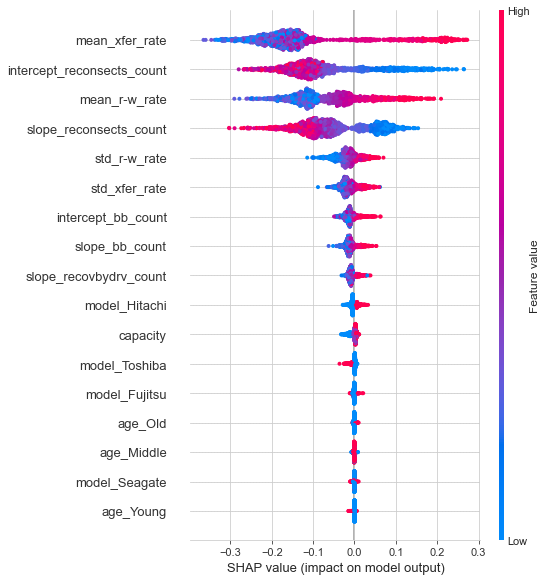

In [36]:
# plot feature importance
plot_top_feature_importance(RF_chosen_model, X_train, top=14)
shap_plot(RF_chosen_model, X_train)